# Прогноз оттока клиентов для оператора связи "ТелеДом"

**Описание:**
Оператор связи "ТелеДом" хочет снизить уровень оттока клиентов, предлагая промокоды и специальные условия пользователям, которые планируют отказаться от услуг связи. Для этого требуется модель машинного обучения, способная предсказывать вероятность разрыва договора.

**Цель проекта:**
Разработка и внедрение предиктивной модели, позволяющей заранее выявлять потенциальных абонентов, склонных к отказу от услуг, на основе их персональных данных, информации о тарифах и услугах.

**Структура проекта**

1. **Загрузка, исследовательский анализ данных и предобработка**

- Загрузка данных.

- Проверка на наличие пропущенных значений, просмотр уникальных значений, типов данных .

- Анализ статистических характеристик данных (методы describe(), info()).

- Визуализация данных (гистограммы, боксплоты, распределения признаков) и анализ распределения признаков.

- Поиск выбросов и аномалий, и их последующие устранение.

2. **Объединение данных**

- Поиск и объединение по общему ключу.

- Проверка корректности объединения.

3. **Исследовательский анализ объединенного датафрейма**

- Генерация дополнительных признаков.

- Анализ корреляций между признаками и целевой переменной.

- Проверка мультиколлинеарности.

- Cравнить распределения признаков для ушедших и оставшихся клиентов/

- Выводы о значимости различных факторов в прогнозе оттока.

4. **Подготовка данных**

- Выделение целевой переменной.

- Разделение выборки на тренировочную и тестовую в соотношении 75/25.

5. **Обучение моделей**

- Создание пайплайна для предобработки данных (нормализация, стандартизация, кодирование категориальных признаков).

- Настройка гиперпараметров моделей.

- Включение гиперпараметров моделей в пайплайн для оптимизации (GridSearchCV, RandomizedSearchCV).

- Выбор нескольких алгоритмов машинного обучения.

- Обучение моделей на подготовленных данных.

6. **Выбор и тестирование лучшей модели**

- Сравнение моделей по метрике ROC-AUC на кросс-валидации.

- Выбор наиболее эффективной модели.

- Тестирование на отложенной тестовой выборке.

- Интерпретация результатов модели.

7. **Выводы и рекомендации заказчику**

- Итоговые результаты прогноза оттока клиентов.

- Возможные пути улучшения модели.

# Используемые функции и константы

In [1]:
def analyze_data(df):
    """"
    Функция для анализа данных.
    - Проверяет пропущенные значения
    - Показывает типы данных
    - Выводит уникальные значения
    - Отображает статистику данных
    
    Параметры:
    df (pd.DataFrame): Исходный DataFrame
    
    Возвращает:
    None (выводит информацию в консоль)
    """
    print(colored('Общая информация о данных:', 'cyan', attrs=['bold']))
    print(df.info())
    print('\n' + '-'*50 + '\n')
    
    print(colored('Статистические характеристики:', 'green', attrs=['bold']))
    print(df.describe())
    print('\n' + '-'*50 + '\n')
    
    print(colored('Пропущенные значения:', 'red', attrs=['bold']))
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    if not missing_values.empty:
        print(missing_values.sort_values(ascending=False))
    else:
        print('Пропущенных значений нет!')
    print('\n' + '-'*50 + '\n')
    
    print(colored('Уникальные значения в столбцах:', 'blue', attrs=['bold']))
    print(f'{df.nunique()} уникальных значений')
    print('\n' + '-'*50 + '\n')

In [2]:
def visualize_and_clean_data(df):
    """
    Функция выполняет визуализацию данных и анализ выбросов.
    - Создаёт гистограммы и boxplot для числовых признаков
    - Строит круговые диаграммы для категориальных переменных
    - Анализирует выбросы по IQR с выводом отчёта
    
    Параметры:
    df (pd.DataFrame): Исходный DataFrame
    
    Возвращает:
    pd.DataFrame: Исходный DataFrame без изменений
    """
    df_clean = df.copy()
    df_without_id = df_clean.drop(columns=['customerID'], errors='ignore')
    
    numeric_cols = df_without_id.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df_without_id.select_dtypes(include=['object']).columns.tolist()
    
    # Визуализация числовых признаков
    if numeric_cols:
        num_rows = len(numeric_cols)
        fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
        fig.suptitle("Анализ числовых признаков", fontsize=16, y=1.02)
        
        if num_rows == 1:
            axes = np.reshape(axes, (1, -1))
        
        for i, col in enumerate(numeric_cols):
            sns.histplot(df_clean[col], kde=True, bins=30, ax=axes[i, 0], color='blue')
            axes[i, 0].set_title(f"Гистограмма: {col}")
            
            sns.boxplot(x=df_clean[col], ax=axes[i, 1], color='red')
            axes[i, 1].set_title(f"Boxplot: {col}")
        
        plt.tight_layout()
        plt.show()
    
    # Визуализация категориальных признаков
    if categorical_cols:
        num_plots = len(categorical_cols)
        cols_per_row = 2
        rows = (num_plots + cols_per_row - 1) // cols_per_row
        
        fig, axes = plt.subplots(rows, cols_per_row, figsize=(12, 8 * rows))
        fig.suptitle("Анализ категориальных признаков", fontsize=16, y=1.02)
        
        axes = axes.flatten() if rows > 1 else axes
        
        for i, col in enumerate(categorical_cols):
            counts = df_clean[col].value_counts()
            axes[i].pie(
                counts, 
                labels=counts.index, 
                autopct='%1.1f%%',
                startangle=90,
                colors=sns.color_palette("flare", len(counts)),
                textprops={'fontsize': 13}
            )
            axes[i].set_title(f"Распределение: {col}", fontsize=16)
        
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Анализ выбросов (без удаления)
    outliers_report = {}
    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        outliers = df_clean[(df_clean[col] < lower) | (df_clean[col] > upper)]
        if not outliers.empty:
            outliers_report[col] = {
                'count': len(outliers),
                'min': outliers[col].min(),
                'max': outliers[col].max(),
                'mean': outliers[col].mean()
            }
    
    # Вывод детального отчета
    if outliers_report:
        print("Обнаруженные выбросы (IQR метод):")
        for col, stats in outliers_report.items():
            print(f"\n* {col}:")
            print(f"  - Количество выбросов: {stats['count']}")
    else:
        print("Выбросы не обнаружены.")
    
    return df

In [3]:
def plot_by_target(df, target_column='customer_left'):
    stayed = df[df[target_column] == 'No']
    left = df[df[target_column] == 'Yes']
    
    for column in df.columns:
        if column != target_column:
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            fig.suptitle(f'Распределение признака "{column}" по {target_column}')
            
            if df[column].dtype == 'object':
                stayed[column].value_counts().plot.pie(ax=axes[0],
                                                       autopct='%1.1f%%',
                                                       startangle=90,
                                                       colors=sns.color_palette('flare'))
                axes[0].set_title('Оставшиеся')
                axes[0].set_ylabel('')
                
                left[column].value_counts().plot.pie(ax=axes[1],
                                                     autopct='%1.1f%%',
                                                     startangle=90,
                                                     colors=sns.color_palette('flare'))
                axes[1].set_title('Ушедшие')
                axes[1].set_ylabel('')
            
            else:
                sns.histplot(stayed[column],
                             ax=axes[0],
                             kde=True,
                             color='blue',
                             label='Оставшиеся')
                axes[0].set_title('Оставшиеся')
                axes[0].set_xlabel(column)
                axes[0].set_ylabel('Количество')
                
                sns.histplot(left[column],
                             ax=axes[1],
                             kde=True,
                             color='red',
                             label='Ушедшие')
                axes[1].set_title('Ушедшие')
                axes[1].set_xlabel(column)
                axes[1].set_ylabel('Количество')
            
            plt.tight_layout()
            plt.show()

In [4]:
RANDOM_STATE = 100325

data_load = '2020-02-01'

# Используемые библиотеки

In [5]:
!pip install -Uq scikit-learn
!pip install matplotlib==3.5.0 -q
!pip install phik -q
!pip install 'lightgbm[scikit-learn]' -q

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from termcolor import colored
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score

## Загрузка, исследовательский анализ данных и предобработка

In [7]:
contract_info = pd.read_csv('/datasets/contract_new.csv')

personal_info = pd.read_csv('/datasets/personal_new.csv')

internet_service = pd.read_csv('/datasets/internet_new.csv')

tele_service = pd.read_csv('/datasets/phone_new.csv')

In [8]:
display(contract_info.head())

display(personal_info.head())

display(internet_service.head())

display(tele_service.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Данные загружены, переходим к первичному анализу.

In [9]:
analyze_data(contract_info)

Общая информация о данных:
,<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 7043 entries, 0 to 7042
,Data columns (total 8 columns):
, #   Column            Non-Null Count  Dtype  
,---  ------            --------------  -----  
, 0   customerID        7043 non-null   object 
, 1   BeginDate         7043 non-null   object 
, 2   EndDate           7043 non-null   object 
, 3   Type              7043 non-null   object 
, 4   PaperlessBilling  7043 non-null   object 
, 5   PaymentMethod     7043 non-null   object 
, 6   MonthlyCharges    7043 non-null   float64
, 7   TotalCharges      7043 non-null   object 
,dtypes: float64(1), object(7)
,memory usage: 440.3+ KB
,None
,
,--------------------------------------------------
,
,Статистические характеристики:
,       MonthlyCharges
,count     7043.000000
,mean        64.761692
,std         30.090047
,min         18.250000
,25%         35.500000
,50%         70.350000
,75%         89.850000
,max        118.750000
,
,------------------------

**Особенности признаков**
- **`TotalCharges`:** Признак хранится как `object`, хотя должен быть числовым. Это требует преобразования для корректного анализа и расчетов.


- **`BeginDate`:** Данные хранятся в формате `object`. Для удобства анализа их стоит преобразовать в формат даты.  


- **`EndDate`:** Это целевой признак. Его необходимо перекодировать в бинарный формат: 1 (если указана дата) и 0 (если стоит `No`). Это упростит дальнейшее использование в моделях.  

In [10]:
contract_info['TotalCharges'] = pd.to_numeric(contract_info['TotalCharges'], errors='coerce')

contract_info['BeginDate'] = pd.to_datetime(contract_info['BeginDate'])

contract_info['customer_left'] = contract_info['EndDate'].apply(lambda x: 'Yes' if x != 'No' else 'No')

In [11]:
contract_info = contract_info.loc[contract_info['BeginDate']<data_load]

Были приведены типы данных для столбцов `BeginDate` и `TotalCharges`. Также был выведен целевой признак `customer_left`, а его прародитель `EndDate` был удален.

`BeginDate` был отфильтрован по дате выгрузки датасета, чтобы не получить "данные из будущего"

In [12]:
analyze_data(contract_info)

Общая информация о данных:
,<class 'pandas.core.frame.DataFrame'>
,Int64Index: 7032 entries, 0 to 7042
,Data columns (total 9 columns):
, #   Column            Non-Null Count  Dtype         
,---  ------            --------------  -----         
, 0   customerID        7032 non-null   object        
, 1   BeginDate         7032 non-null   datetime64[ns]
, 2   EndDate           7032 non-null   object        
, 3   Type              7032 non-null   object        
, 4   PaperlessBilling  7032 non-null   object        
, 5   PaymentMethod     7032 non-null   object        
, 6   MonthlyCharges    7032 non-null   float64       
, 7   TotalCharges      7032 non-null   float64       
, 8   customer_left     7032 non-null   object        
,dtypes: datetime64[ns](1), float64(2), object(6)
,memory usage: 549.4+ KB
,None
,
,--------------------------------------------------
,
,Статистические характеристики:
,       MonthlyCharges  TotalCharges
,count     7032.000000   7032.000000
,mean        64.

**Размерность и структура**
- Датасет содержит **7043 записи** и **8 столбцов**.

**Пропущенные значения**
- После преобразований было найдено 11 пропущенных значений в столбце `TotalCharges`, удалим их так как количество небольшое.

**Статистические характеристики**
- `MonthlyCharges` варьируются от **18.25** до **118.75**, среднее значение — **64.76**.
- `TotalCharges` варьируются от **19.05** до **9221.38**, среднее значение — **2118.62**.

**Категориальные признаки**
- `Type` (3 значения), `PaperlessBilling` (2 значения), `PaymentMethod` (4 значения) — потенциально важны для модели.
- `customerID` содержит уникальные идентификаторы по которым мы будем объединять таблицы.
- `customer_left` имеет два значения и является целевым признаком.

In [13]:
contract_info = contract_info.dropna(subset=['TotalCharges'])

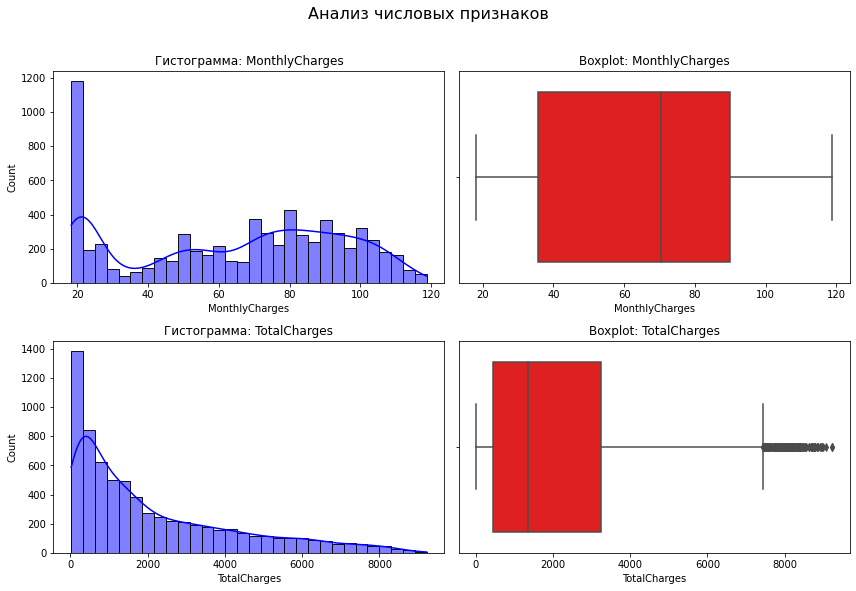

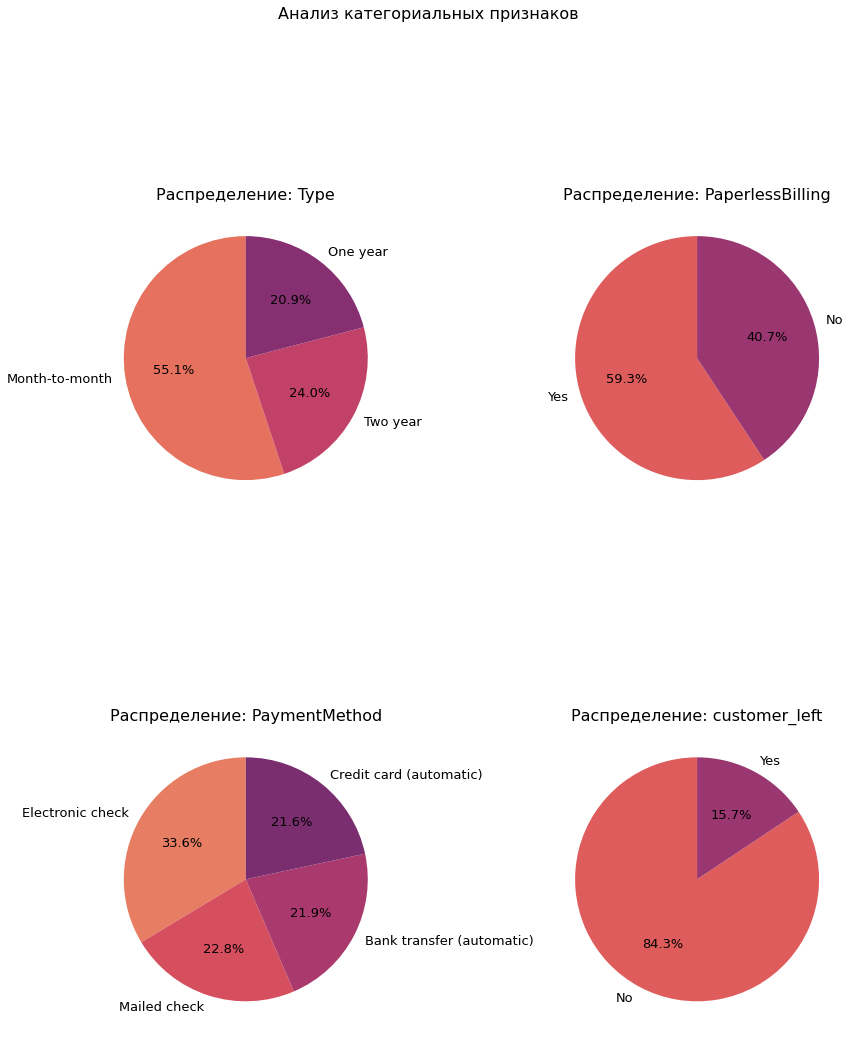

Обнаруженные выбросы (IQR метод):
,
,* TotalCharges:
,  - Количество выбросов: 195


In [14]:
temp_df = contract_info.copy()

temp_df = temp_df.drop('EndDate', axis=1)

temp_df = visualize_and_clean_data(temp_df)

**Количественные признаки**
- **`MonthlyCharges`:** Большинство значений сосредоточено в районе 20 единиц, выбросы отсутствуют. Это указывает на стабильность ежемесячных расходов клиентов.  


- **`TotalCharges`:** Основная часть значений лежит в диапазоне от 0 до 1000 единиц. Удалено 195 выбросов, превышающих 75-й квартиль, что улучшило качество данных. 


**Качественные признаки**

- **`Type`:** Самый популярный тип оплаты — ежемесячный (55.1%). Это говорит о предпочтении клиентов гибкости в оплате услуг.  


- **`PaperlessBilling`:** Безналичный расчет выбрали 59.3% клиентов, что отражает тенденцию к переходу на электронные платежи. 


- **`PaymentMethod`:** Методы оплаты распределены равномерно, но электронный чек лидирует с 33.6%. Это может быть связано с удобством использования.  


- **`customer_left`:** 84.3% пользователей остались, 15.7% ушли. Признак целевой, но наблюдается дисбаланс классов. Это важно учесть при построении моделей, чтобы избежать смещения в предсказаниях.  

In [15]:
analyze_data(personal_info)

Общая информация о данных:
,<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 7043 entries, 0 to 7042
,Data columns (total 5 columns):
, #   Column         Non-Null Count  Dtype 
,---  ------         --------------  ----- 
, 0   customerID     7043 non-null   object
, 1   gender         7043 non-null   object
, 2   SeniorCitizen  7043 non-null   int64 
, 3   Partner        7043 non-null   object
, 4   Dependents     7043 non-null   object
,dtypes: int64(1), object(4)
,memory usage: 275.2+ KB
,None
,
,--------------------------------------------------
,
,Статистические характеристики:
,       SeniorCitizen
,count    7043.000000
,mean        0.162147
,std         0.368612
,min         0.000000
,25%         0.000000
,50%         0.000000
,75%         0.000000
,max         1.000000
,
,--------------------------------------------------
,
,Пропущенные значения:
,Пропущенных значений нет!
,
,--------------------------------------------------
,
,Уникальные значения в столбцах:
,customerID    

**Особенности признаков**
- Типы данных приведены к корректным форматам, что упрощает их обработку и анализ. 


- Пропуски в данных отсутствуют — это избавляет от необходимости их заполнения или удаления.  


- Количество уникальных значений соответствует ожидаемому, что подтверждает корректность данных.  


- Признак `SeniorCitizen` будет переведен в категориальный формат ('Yes' и 'No') для удобства использования в функции и улучшения читаемости данных.  

In [16]:
personal_info['SeniorCitizen'] = personal_info['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

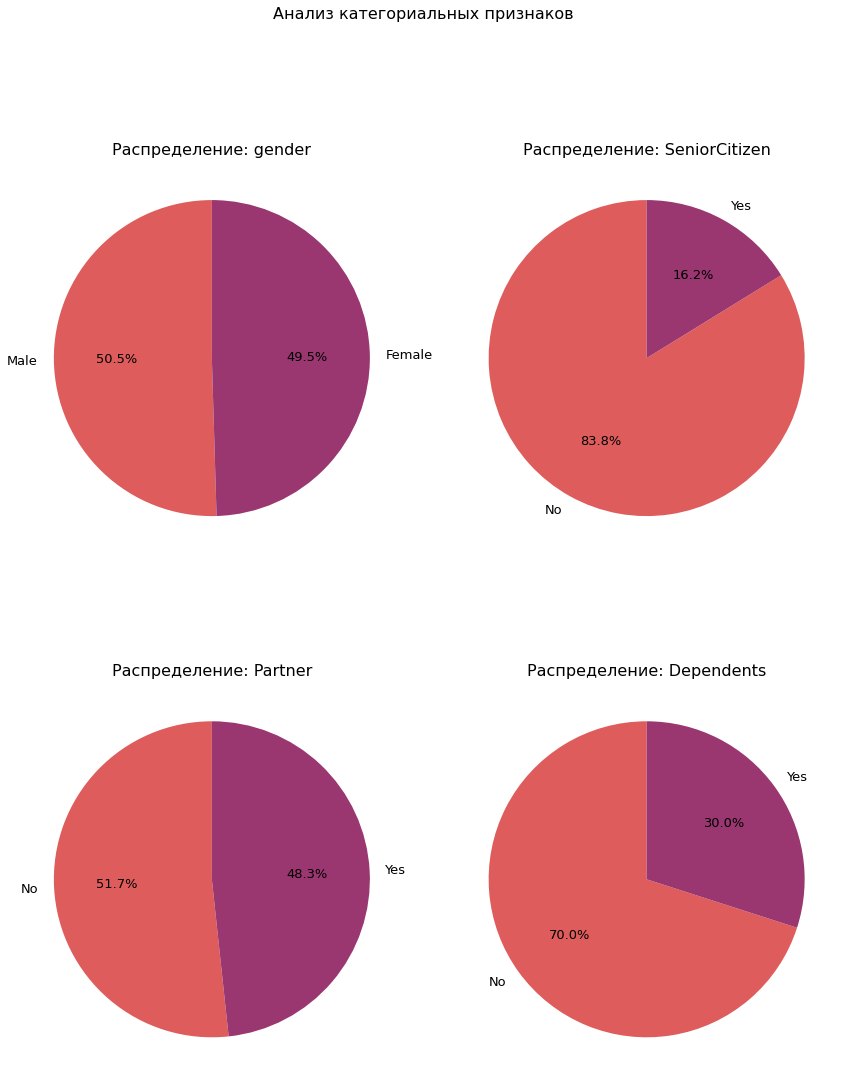

Выбросы не обнаружены.


In [17]:
personal_info = visualize_and_clean_data(personal_info) 

**Качественные признаки**

- **Пол (`gender`):** Распределение почти равное — 50 на 50. Это говорит о сбалансированности данных по гендерному признаку.  

- **Пенсионный статус (`SeniorCitizen`):** Большинство пользователей (83.8%) не являются пенсионерами, только 16.2% имеют этот статус. Это указывает на то, что основная аудитория — люди трудоспособного возраста.  

- **Наличие супруга(и) (`Partner`):** Распределение 50 на 50. Половина пользователей состоит в отношениях, другая половина — нет.  

- **Иждивенцы (`Dependents`):** У 30% пользователей есть иждивенцы, у 70% — нет. Это может влиять на выбор услуг, так как пользователи с иждивенцами чаще нуждаются в дополнительных опциях.  

In [18]:
analyze_data(internet_service)

Общая информация о данных:
,<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 5517 entries, 0 to 5516
,Data columns (total 8 columns):
, #   Column            Non-Null Count  Dtype 
,---  ------            --------------  ----- 
, 0   customerID        5517 non-null   object
, 1   InternetService   5517 non-null   object
, 2   OnlineSecurity    5517 non-null   object
, 3   OnlineBackup      5517 non-null   object
, 4   DeviceProtection  5517 non-null   object
, 5   TechSupport       5517 non-null   object
, 6   StreamingTV       5517 non-null   object
, 7   StreamingMovies   5517 non-null   object
,dtypes: object(8)
,memory usage: 344.9+ KB
,None
,
,--------------------------------------------------
,
,Статистические характеристики:
,        customerID InternetService OnlineSecurity OnlineBackup  \
,count         5517            5517           5517         5517   
,unique        5517               2              2            2   
,top     2988-GBIVW     Fiber optic             No     

**Особенности признаков**
- Типы данных приведены к корректным форматам, что упрощает дальнейший анализ.  


- Пропуски в данных отсутствуют, что избавляет от необходимости их заполнения или удаления.  


- Количество уникальных значений соответствует ожидаемому, что говорит о корректности данных.  


- В таблице содержится 5517 строк, что на 1526 строк меньше, чем в предыдущих таблицах (7043 строки). Это может привести к потере данных при объединении: либо появятся пустые столбцы, либо придется удалить около 2000 строк.  


- Отсутствие строк для определенного пользователя в этой таблице может указывать на то, что клиент перестал пользоваться услугами оператора. Это предположение будет проверено на этапе объединения таблиц.  

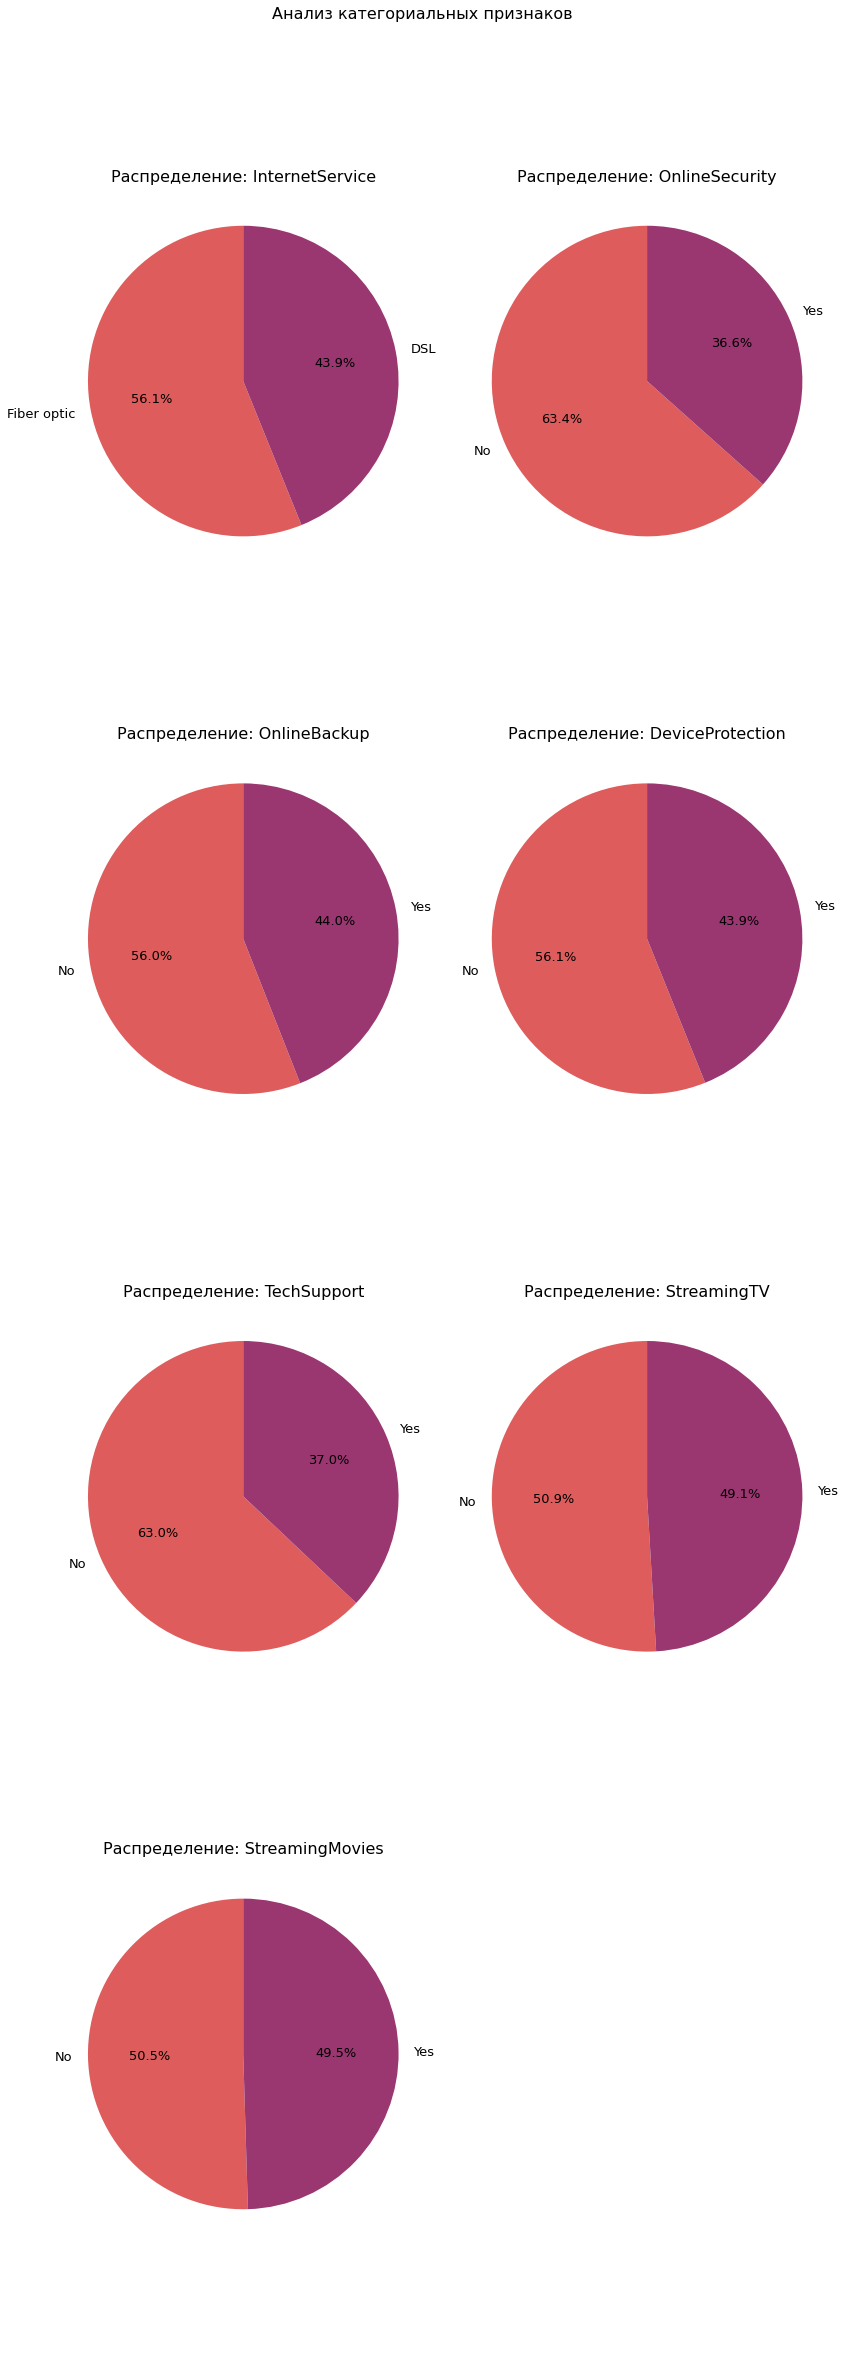

Выбросы не обнаружены.


In [19]:
internet_service = visualize_and_clean_data(internet_service) 

**InternetService**
- **Распределение:**  
  - Кабель: 44%  
  - Цифра: 56%  
  **Вывод:** Большинство клиентов используют цифровые интернет-услуги.

**OnlineSecurity**
- **Распределение:**  
  - Отказались от блокировки небезопасных сайтов: 64.4%  
  **Вывод:** Большинство пользователей не используют дополнительную защиту от небезопасных сайтов.

**OnlineBackup**
- **Распределение:**  
  - Отказались от облачного хранилища: 56%  
  **Вывод:** Более половины клиентов не используют облачное хранилище для резервного копирования.

**DeviceProtection**
- **Распределение:**  
  - Отказались от антивирусной защиты: 56%  
  **Вывод:** Большинство пользователей не используют антивирусную защиту для устройств.

**TechSupport**
- **Распределение:**  
  - Нет выделенной линии техподдержки: 63%  
  **Вывод:** Большинство клиентов не имеют доступа к выделенной линии технической поддержки.

**StreamingTV и StreamingMovies**
- **Распределение:**  
  - Примерно 50 на 50
  **Вывод:** Услуги стриминга телевидения и фильмов распределены равномерно среди клиентов.

---

Общий вывод:
- Большинство клиентов предпочитают цифровые интернет-услуги.  


- Значительная часть пользователей отказывается от дополнительных услуг, таких как блокировка небезопасных сайтов, облачное хранилище, антивирусная защита и выделенная техподдержка.


- Услуги стриминга (TV и Movies) пользуются равномерным спросом.

In [20]:
analyze_data(tele_service)

Общая информация о данных:
,<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 6361 entries, 0 to 6360
,Data columns (total 2 columns):
, #   Column         Non-Null Count  Dtype 
,---  ------         --------------  ----- 
, 0   customerID     6361 non-null   object
, 1   MultipleLines  6361 non-null   object
,dtypes: object(2)
,memory usage: 99.5+ KB
,None
,
,--------------------------------------------------
,
,Статистические характеристики:
,        customerID MultipleLines
,count         6361          6361
,unique        6361             2
,top     4759-PXTAN            No
,freq             1          3390
,
,--------------------------------------------------
,
,Пропущенные значения:
,Пропущенных значений нет!
,
,--------------------------------------------------
,
,Уникальные значения в столбцах:
,customerID       6361
,MultipleLines       2
,dtype: int64 уникальных значений
,
,--------------------------------------------------
,


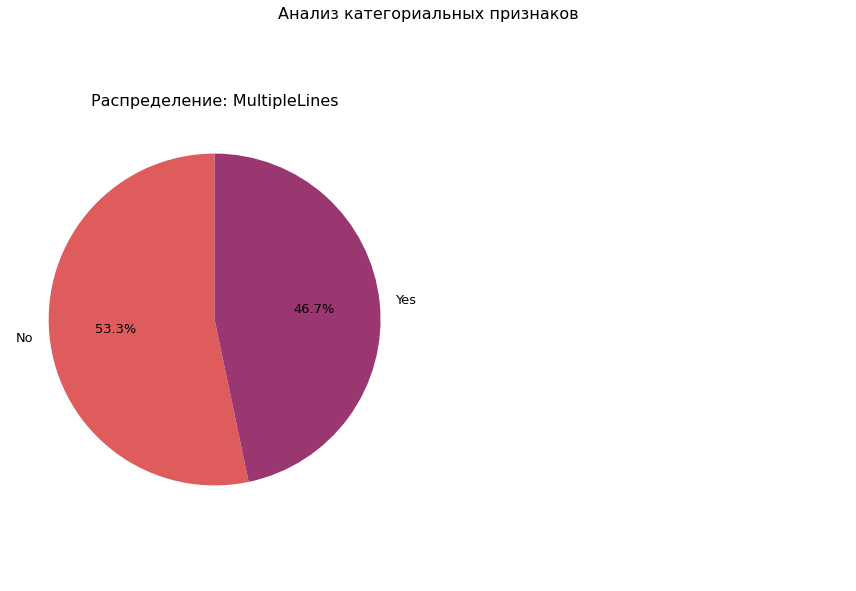

Выбросы не обнаружены.


In [21]:
tele_service = visualize_and_clean_data(tele_service)

Выводы:

- Распределение признака примерно 50 на 50, что указывает на сбалансированность данных.  


- При объединении таблиц пропуски заполним значением `No`, так как отсутствие информации о пользователе логично интерпретировать как отсутствие мультилинии или недоступность услуги для данного клиента.  

Вывод по разделу:


- Данные были загружены.


- Была проведена проверка на наличие пропущенных значений, просмотр уникальных значений, типов данных .


- Был проведен анализ статистических характеристик данных.


- Данные были визуализированы.


- Был выполнен поиск выбросов и аномалий, и их последующие устранение.

## Объединение данных

In [22]:
merged_df = contract_info.merge(personal_info, on='customerID', how='left') \
                         .merge(internet_service, on='customerID', how='left') \
                         .merge(tele_service, on='customerID', how='left')

merged_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,customer_left,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,No,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,No,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,No,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,No,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,No,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [23]:
missing_values = merged_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
if not missing_values.empty:
    print(missing_values.sort_values(ascending=False))
else:
    print("Пропущенных значений нет!")

InternetService     1520
,OnlineSecurity      1520
,OnlineBackup        1520
,DeviceProtection    1520
,TechSupport         1520
,StreamingTV         1520
,StreamingMovies     1520
,MultipleLines        680
,dtype: int64


**Для интернет-услуг:**

Поскольку у всех клиентов есть интернет (`DSL` или `Fiber optic`), пропуски в связанных услугах (`OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`) заполняем значением No, так как клиент их попросту не подключал.

**Для MultipleLines:**

Пропуски заполняем значением `No`, так как отсутствие данных может означать, что услуга недоступна или не используется.

In [24]:
internet_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

merged_df[internet_columns] = merged_df[internet_columns].fillna('No')

merged_df['MultipleLines'] = merged_df['MultipleLines'].fillna('No')

In [25]:
missing_values = merged_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
if not missing_values.empty:
    print(missing_values.sort_values(ascending=False))
else:
    print("Пропущенных значений нет!")

InternetService    1520
,dtype: int64


Посмотрим, как часто дополнительные услуги встречаются для каждого типа интернета.

Если в DSL дополнительные услуги встречаются чаще, а в Fiber optic реже, то это можно использовать для заполнения пропусков.

In [26]:
for col in internet_columns:
    print(f"Распределение для {col}:")
    print(merged_df.groupby('InternetService')[col].value_counts(normalize=True))
    print("\n" + "="*50 + "\n")

Распределение для OnlineSecurity:
,InternetService  OnlineSecurity
,DSL              No                0.513245
,                 Yes               0.486755
,Fiber optic      No                0.729005
,                 Yes               0.270995
,Name: OnlineSecurity, dtype: float64
,
,==================================================
,
,Распределение для OnlineBackup:
,InternetService  OnlineBackup
,DSL              No              0.552152
,                 Yes             0.447848
,Fiber optic      No              0.566214
,                 Yes             0.433786
,Name: OnlineBackup, dtype: float64
,
,==================================================
,
,Распределение для DeviceProtection:
,InternetService  DeviceProtection
,DSL              No                  0.560844
,                 Yes                 0.439156
,Fiber optic      No                  0.561693
,                 Yes                 0.438307
,Name: DeviceProtection, dtype: float64
,
,============================

In [27]:
merged_df['InternetService'] = merged_df['InternetService'].fillna('No')

In [28]:
missing_values = merged_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
if not missing_values.empty:
    print(missing_values.sort_values(ascending=False))
else:
    print("Пропущенных значений нет!")

Пропущенных значений нет!


Вывод по разделу:


- Таблицы были объеденены по ключу `customerID`.


- Пропуски заполнены. Особенного внимания стоил столбец `InternetService`.

## Исследовательский анализ объединенного датафрейма

Создадим новые признаки

In [29]:
# Для действующих клиентов заменяем EndDate на дату выгрузки данных
merged_df['EffectiveEndDate'] = np.where(
    merged_df['customer_left'] == 'No',
    data_load,  # Используем дату выгрузки данных для действующих клиентов
    merged_df['EndDate']  # Для ушедших клиентов используем EndDate
)

# Преобразуем EffectiveEndDate в datetime
merged_df['EffectiveEndDate'] = pd.to_datetime(
    merged_df['EffectiveEndDate'], 
    errors='coerce'  # Игнорируем ошибки, если они возникнут
)

# Рассчитываем Tenure в месяцах
merged_df['Tenure'] = round(
    (merged_df['EffectiveEndDate'] - merged_df['BeginDate']).dt.days)

merged_df.drop('EffectiveEndDate', axis=1, inplace=True)

In [30]:
merged_df['TotalServices'] = merged_df[internet_columns].apply(lambda x: x[x != 'No'].count(), axis=1)

In [31]:
merged_df['AverageMonthlySpending'] = merged_df['TotalCharges'] / merged_df['Tenure']

merged_df['AverageMonthlySpending'] = merged_df['AverageMonthlySpending'].replace([np.inf, -np.inf], 0)

In [32]:
merged_df['HasFamily'] = (
    (merged_df['Dependents'] == 'Yes') & (merged_df['SeniorCitizen'] == 'No')
).apply(lambda x: 'Yes' if x else 'No')

In [33]:
merged_df = merged_df.drop(['BeginDate', 'EndDate'], axis=1)

- `Tenure` (длительность использования услуг): разница между текущей датой и BeginDate.


- `TotalServices` (общее количество услуг): cуммируем количество услуг, которые использует клиент.


- `AverageMonthlySpending` (средний чек за месяц): Отношение TotalCharges к количеству месяцев использования услуг.


- `HasFamily` (наличие семьи с ребенком): Если у клиента есть ребенок, и клиент не `Senior`, то в независимости от наличия партнера - `Yes`, в ином случае `No`, то это может положительно сказаться на продажах, в виде дополнительных сервисов и скидок на их подключение (например интернет защита для ребенка (чтобы не подцепил ничего или не увидел неподходящий для детей контент, или стриминговое тв для мультиков).


- Признак `BeginDate` можно удалить, он ничего не значит для нас.

In [34]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
,Int64Index: 7032 entries, 0 to 7031
,Data columns (total 23 columns):
, #   Column                  Non-Null Count  Dtype  
,---  ------                  --------------  -----  
, 0   customerID              7032 non-null   object 
, 1   Type                    7032 non-null   object 
, 2   PaperlessBilling        7032 non-null   object 
, 3   PaymentMethod           7032 non-null   object 
, 4   MonthlyCharges          7032 non-null   float64
, 5   TotalCharges            7032 non-null   float64
, 6   customer_left           7032 non-null   object 
, 7   gender                  7032 non-null   object 
, 8   SeniorCitizen           7032 non-null   object 
, 9   Partner                 7032 non-null   object 
, 10  Dependents              7032 non-null   object 
, 11  InternetService         7032 non-null   object 
, 12  OnlineSecurity          7032 non-null   object 
, 13  OnlineBackup            7032 non-null   object 
, 14  DeviceProtection     

Построим матрицу корреляции между всеми признаками для проверки корреляцией с целевой переменной.

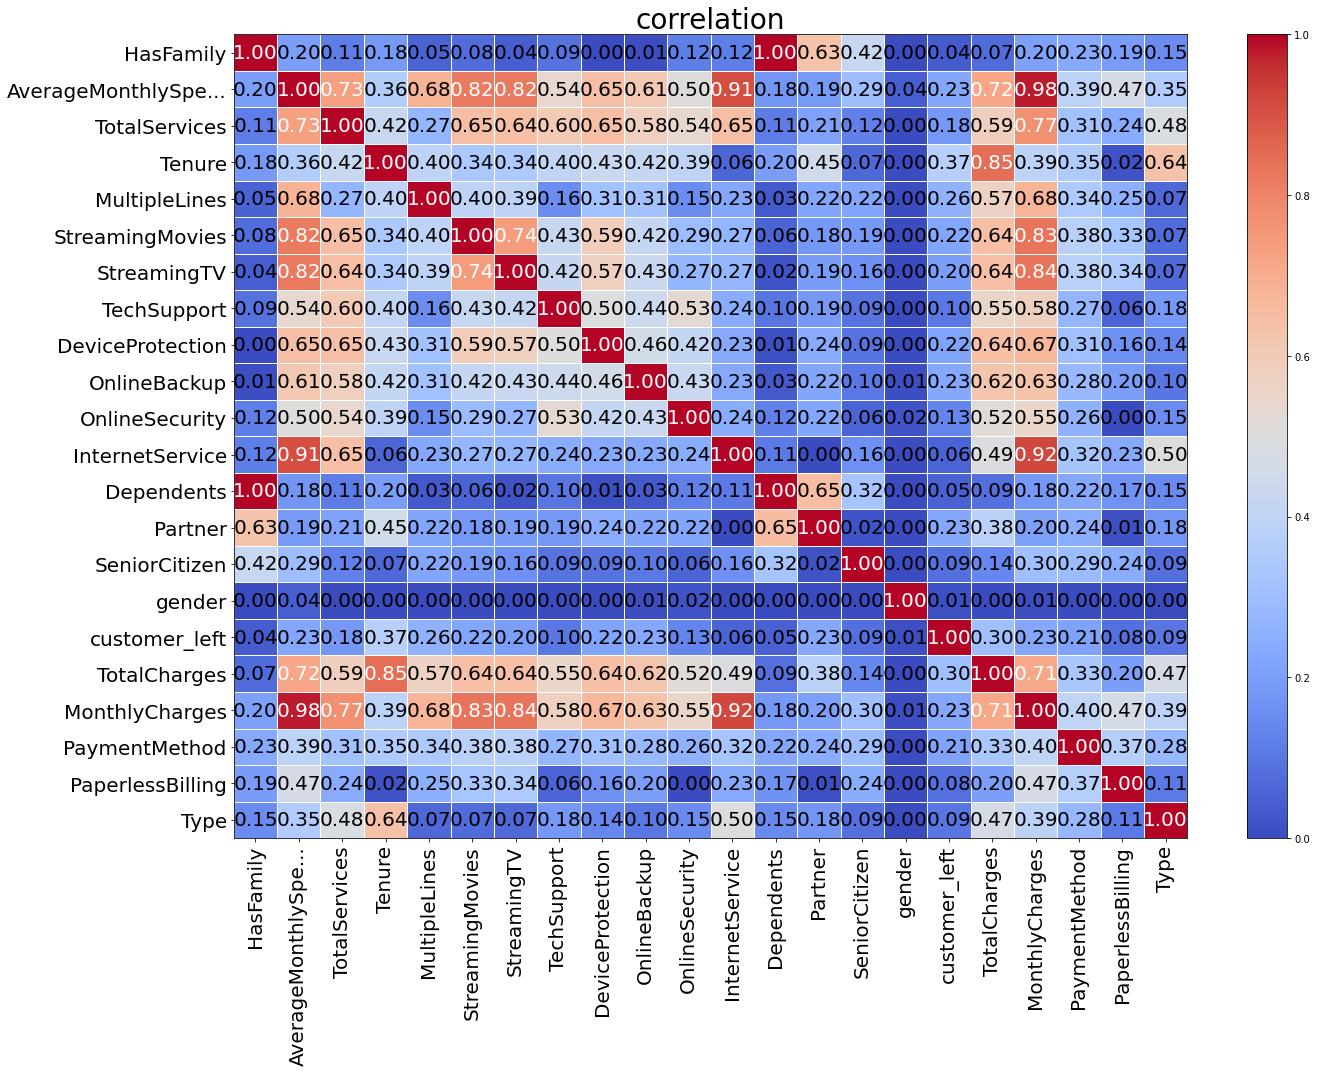

In [35]:
data_phik = merged_df.set_index('customerID')

interval_cols = ['MonthlyCharges', 'TotalCharges', 'Tenure', 'TotalServices', 'AverageMonthlySpending']
phik_overview = phik_matrix(data_phik, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    fontsize_factor=2,
    figsize=(20, 15)
)

Удалим признаки с низкой корреляцией с целевой переменной `customer_left` (>0.1), а именно:

- `HasFamily` - 0.04
- `InternetService` - 0.06
- `Dependents` - 0.05
- `SeniorCitizen` - 0.09
- `gender` - 0.01
- `PaperlessBilling` - 0.08
- `Type` - 0.09

In [36]:
data_phik = data_phik.drop(['HasFamily',
                           'InternetService',
                           'Dependents',
                           'SeniorCitizen',
                           'gender',
                           'PaperlessBilling',
                           'Type'], axis=1)

Перейдем к проверке на мультиколлинеарность между признаками.

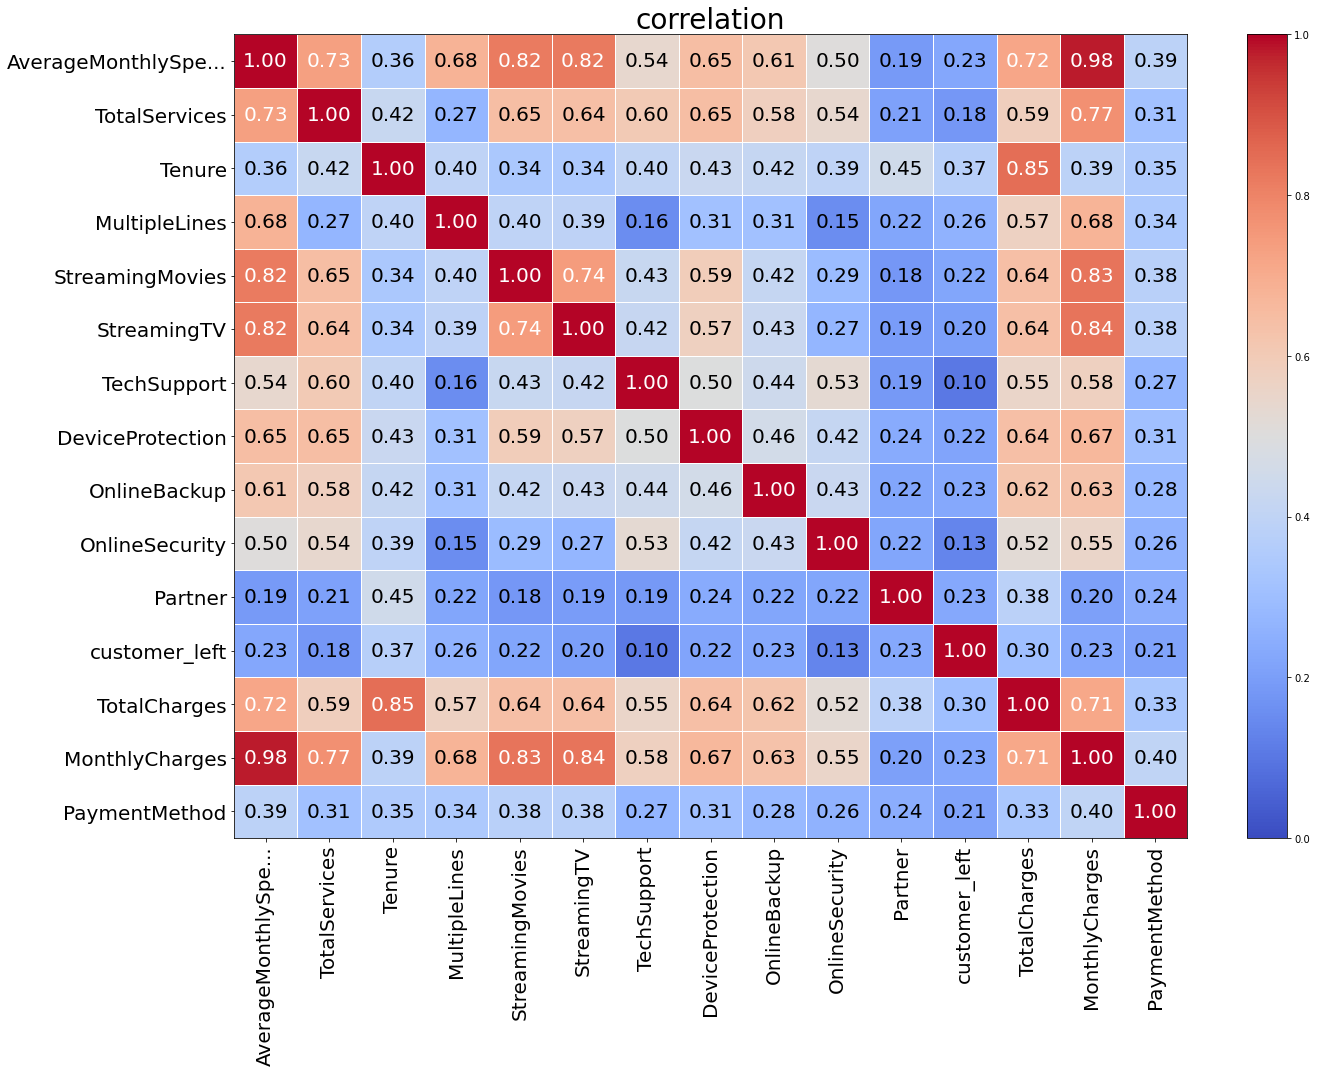

In [37]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'Tenure', 'TotalServices', 'AverageMonthlySpending']
phik_overview = phik_matrix(data_phik, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    fontsize_factor=2,
    figsize=(20, 15)
)

Обнаружена высокая корреляция (>0.8) между: (в скобках указана корреляция признака с целевой переменной)

- `AverageMonthlySpending`(0.22) и `MonthlyCharges`(0.23) в 0.98


- `Tenure`(0.37) и `TotalCharges`(0.3) в 0.85.


- `StreamingMovies` и `StreamingTV` имеют корреляцию с признаком `MonthlyCharges` в 0.82. Но мною было принято принято решение удалить признак `MonthlyCharges`.

In [38]:
data_phik = data_phik.drop(['MonthlyCharges', 'TotalCharges'], axis=1)

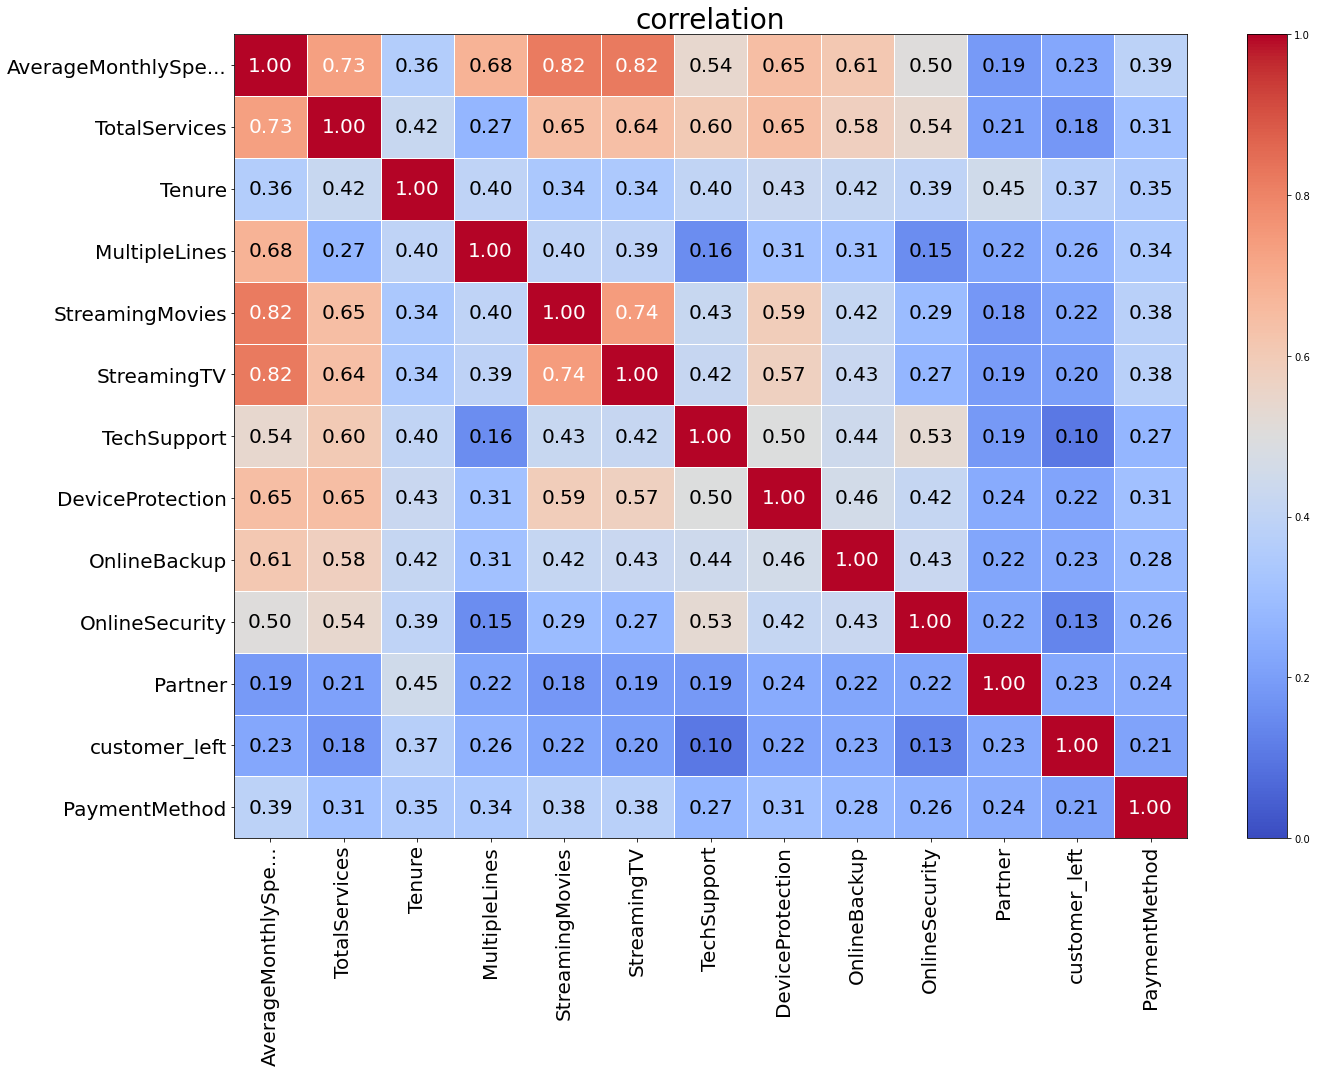

In [39]:
interval_cols = ['Tenure', 'TotalServices', 'AverageMonthlySpending']
phik_overview = phik_matrix(data_phik, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    fontsize_factor=2,
    figsize=(20, 15)
)

Вывод по матрицам корреляции:

- Были созданы новые признаки для большей обучаемости последующей модели.


- Были удалены некоторые признаки во избежании мультиколлинеарность. Отбор для удаления проходил по тому, как коррелирующие признаки влияют на целевую переменную и брали меньший из них.


- Утечек целевого признака не обнаружено


- Наиболее значимыми признаками являются: `Tenure`, `MultipleLines`.


- Наименее значимые признаки: `TotalServices`, `TechSuppor`, `OnlineSecurity`

Перейдем к сравнению распределения признаков для ушедших и оставшихся клиентов.

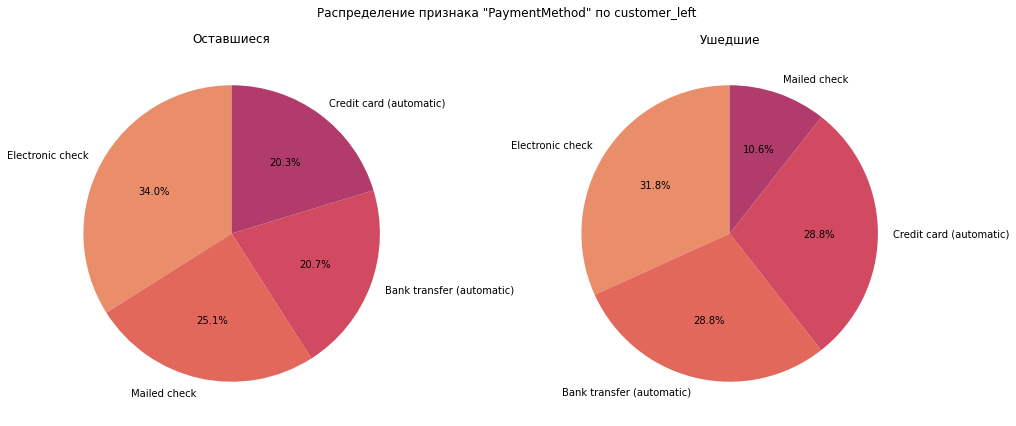

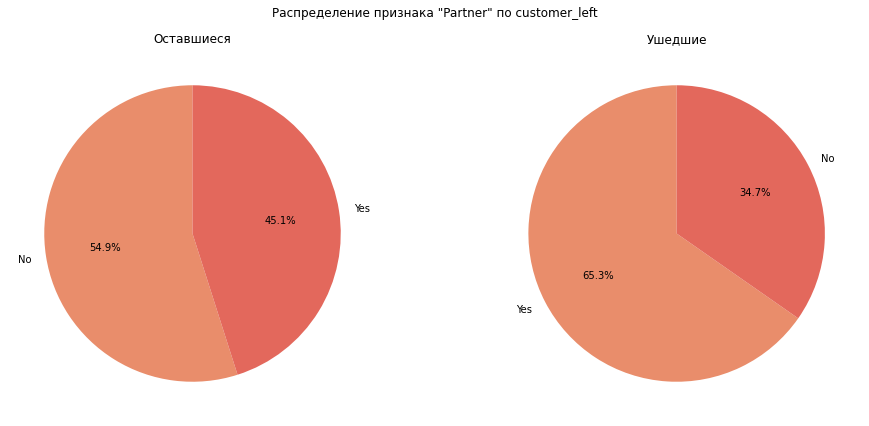

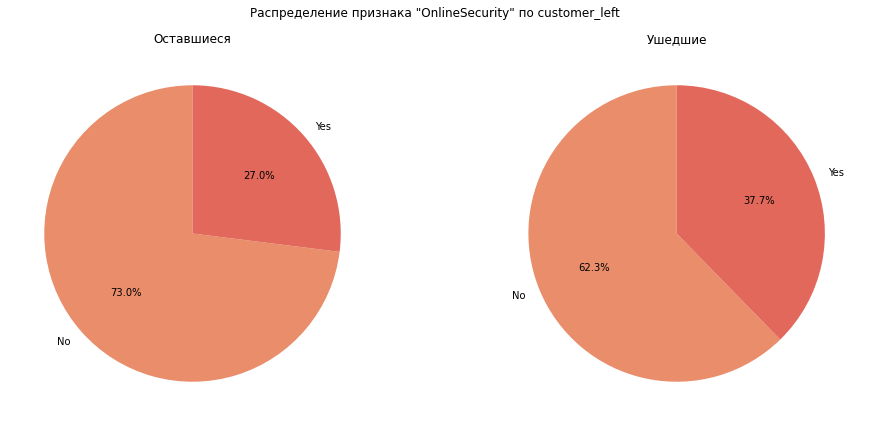

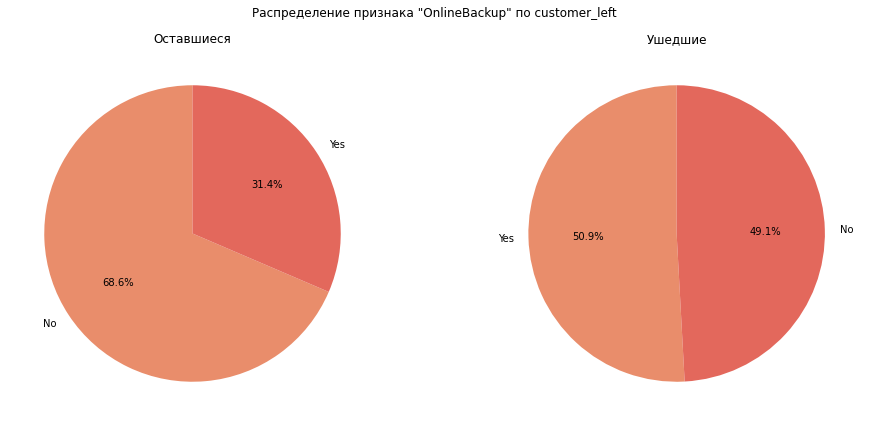

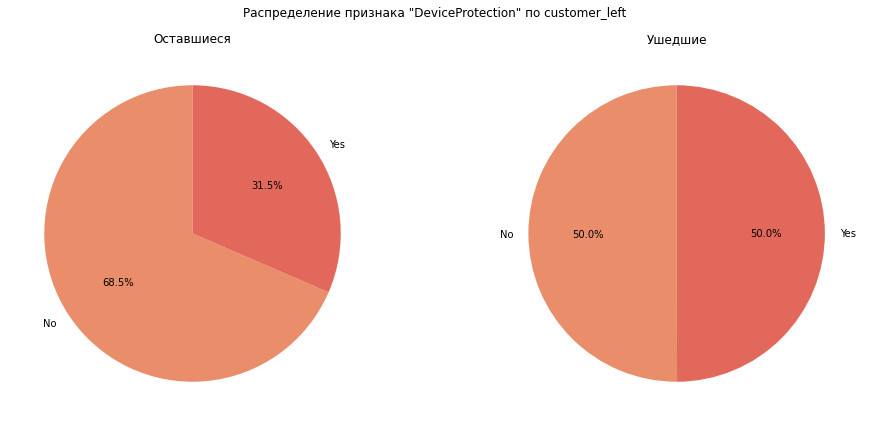

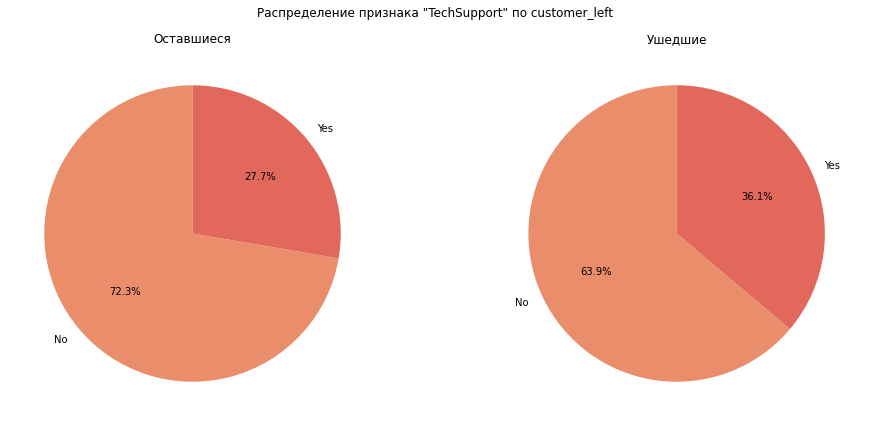

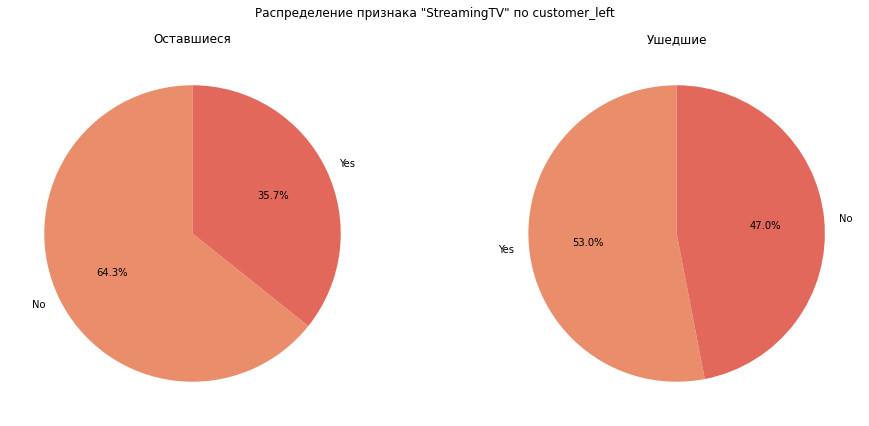

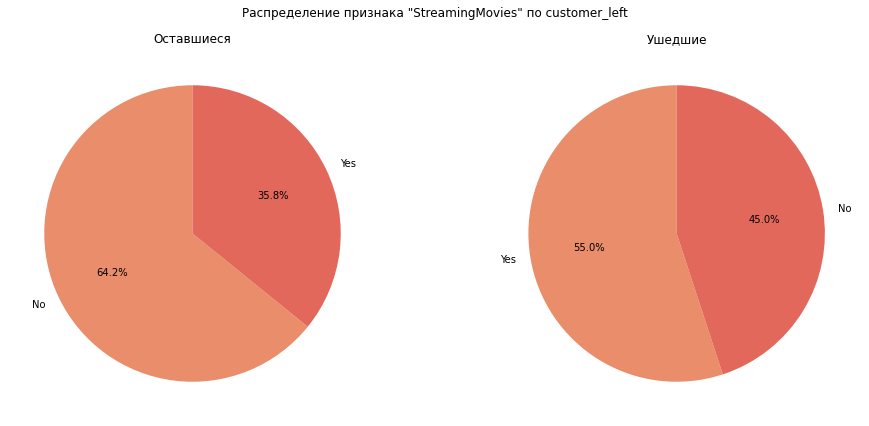

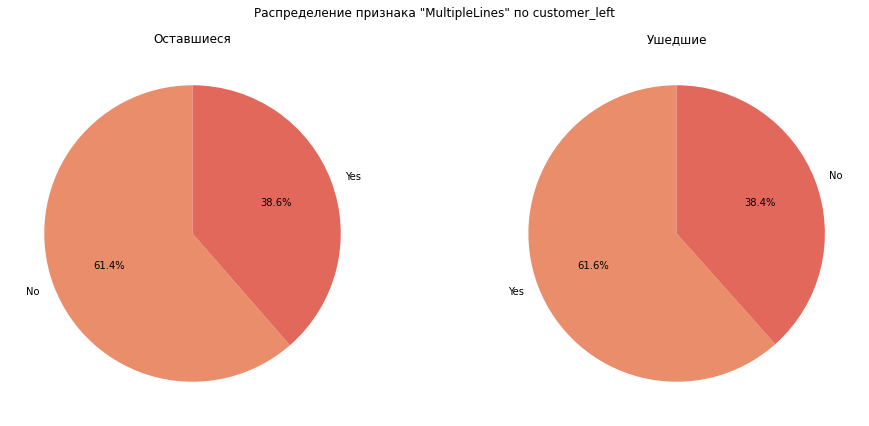

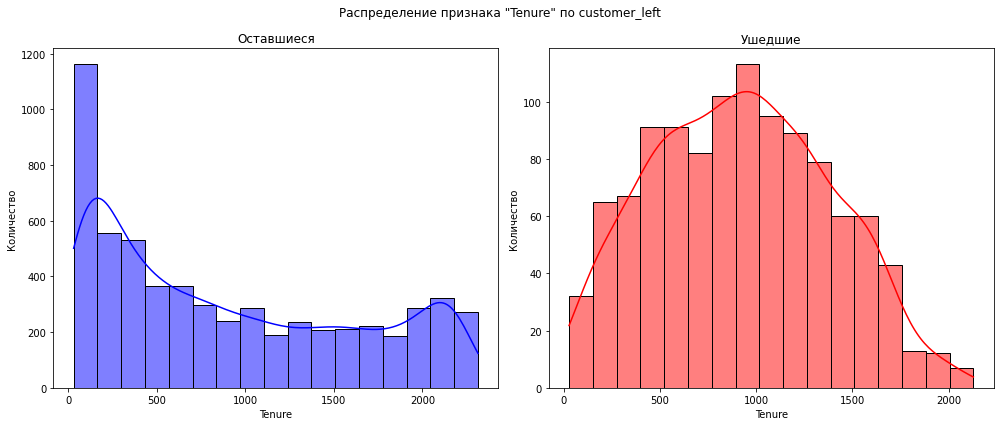

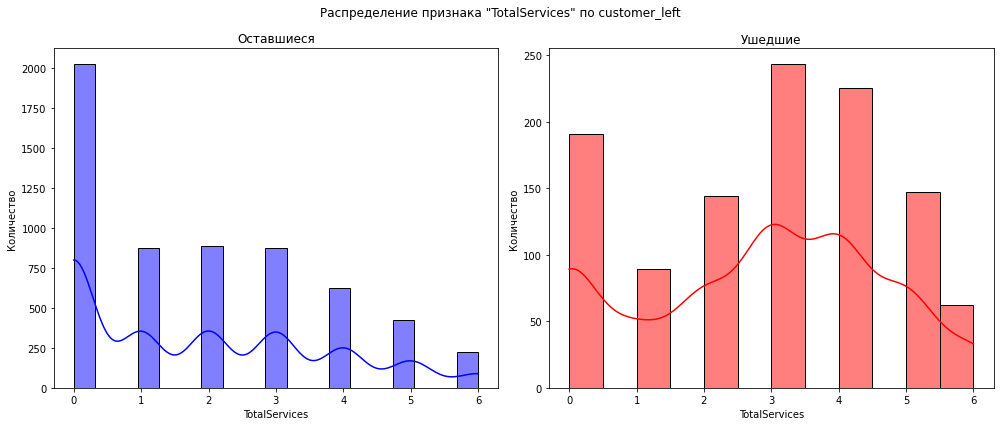

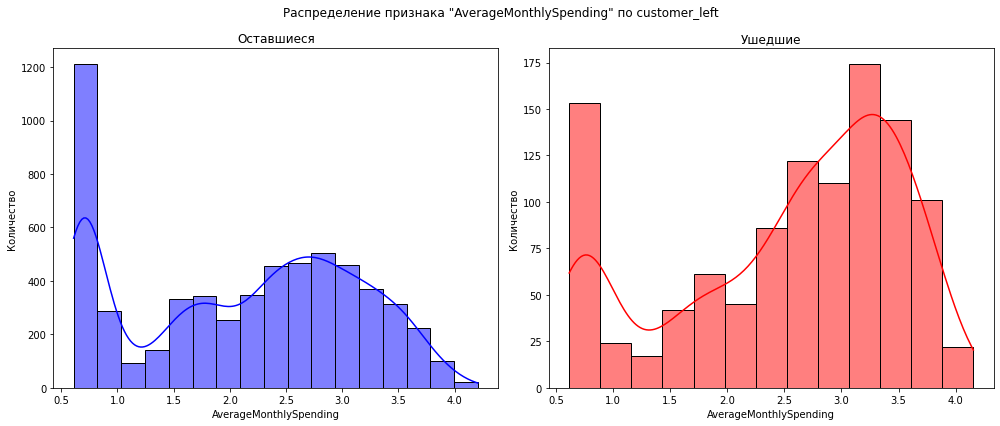

In [40]:
plot_by_target(data_phik)

Вывод:


- `Partner` - У 65 процентов ушедших пользователей был партнер, тогда как у оставшихся этот показатель составлял 44 процента.


- `OnlineBackup` и `DeviceProtection` - У оставшихся пользователей этими услугами пользуются 30 процентов пользователей, тогда как у ушедших это 50 на 50.


- `Tenure` - Мы видим абсолютно противоположные графики. У оставшихся клиентов львиная доля пользуются услугами до 10 месяцев. Большинство ушедших же клиентов наоборот, 25 месяцев. Старички уходят, новички пользуются.


- `TotalServices` - Большинство оставшихся пользователей не подключали доп. услуг, когда как у ушедших популярными были 3 4 и 0 услуг.


- `AverageMonthlySpending` - Большинство пользователей платят около 20 единиц, тогда как у ушедших пользователей этот показатель равен от 80 до 100 единиц.

Выводы по разделу:

- Созданы новые признаки: `Tenure`, `TotalServices`, `AverageMonthlySpending`, `HasFamily` для улучшения обучаемости модели.
- Удалены признаки с низкой корреляцией с целевой переменной (`HasFamily`, `InternetService`, `Dependents`, `SeniorCitizen`, `gender`, `PaperlessBilling`).
- Обнаружена и устранена мультиколлинеарность между признаками: `AverageMonthlySpending` и `MonthlyCharges`, `Tenure` и `TotalCharges`, `StreamingMovies` и `StreamingTV`.
- Наиболее значимые признаки: `MultiLines`, `Tenure`.
- Наименее значимые: `TotalServices`, `TechSupport`, `OnlineSecurity`.
- Утечек целевого признака не выявлено.
- Анализ показал, что у оставшихся клиентов преобладают помесячные платежи, меньшее количество дополнительных услуг и более низкий средний чек. У ушедших клиентов наблюдается обратная тенденция: большее количество услуг, более высокий средний чек и длительный срок использования.

## Подготовка данных

In [41]:
x = data_phik.drop(['customer_left'], axis=1)

y = data_phik['customer_left']

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=RANDOM_STATE)

Вывод по разделу:

- Целевая переменная выделена


- Данные разбиты на тренировочную и тестовую выборки

## Обучение моделей

In [43]:
models = [] # Список для моделей

roc_auc_cross = [] # Список для метрики на кросс-валидации

### LGBMClassifier

In [44]:
# Преобразуем категориальные признаки в тип category, как того требует модель LightGBM
x_train_lgb = x_train.copy()
x_test_lgb = x_test.copy()

categorical_columns = x_train_lgb.select_dtypes(include='object').columns

x_train_lgb[categorical_columns] = x_train_lgb[categorical_columns].astype('category')
x_test_lgb[categorical_columns] = x_test_lgb[categorical_columns].astype('category')

In [45]:
y_train_lgb = y_train.copy()
y_test_lgb = y_test.copy()

y_train_lgb = y_train.map({'Yes': 1, 'No': 0})
y_test_lgb = y_test.map({'Yes': 1, 'No': 0})

In [46]:
pipeline = Pipeline(steps=[
    ('lgbmc',LGBMClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced')
    ) 
])

param_dist = {
    'lgbmc__num_leaves': [31, 50, 100],
    'lgbmc__learning_rate': [0.01, 0.05, 0.1],
    'lgbmc__max_depth': [3, 5, 7],
    'lgbmc__min_child_samples': [10, 20, 30]
}

In [47]:
lgbmc = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lgbmc.fit(x_train_lgb, y_train_lgb)

roc_auc_lgbmc = lgbmc.best_score_
model_lgbmc = lgbmc.best_estimator_

models.append(model_lgbmc)
roc_auc_cross.append(roc_auc_lgbmc)

### DecisionTreeClassifier

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns)
    ],
    remainder='passthrough'
)


In [49]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Шаг предобработки
    ('DecisionTreeClassifier', DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE))
])

param_grid = {
    'DecisionTreeClassifier__max_depth': [3, 5, 7],
    'DecisionTreeClassifier__min_samples_split': [10, 20, 30],
    'DecisionTreeClassifier__min_samples_leaf': [5, 10, 15],
    'DecisionTreeClassifier__criterion': ['gini', 'entropy']
}

In [50]:
dtc = RandomizedSearchCV(pipeline,
                         param_distributions=param_grid,
                         cv=5,
                         scoring='roc_auc',
                         random_state=RANDOM_STATE,
                         n_jobs=-1,
                         n_iter=10
                        )

dtc.fit(x_train, y_train)

roc_auc_dtc = dtc.best_score_
model_dtc = dtc.best_estimator_

models.append(model_dtc)
roc_auc_cross.append(roc_auc_dtc)

### SVC

In [51]:
numerical_columns = x_train.select_dtypes(include=['number']).columns.tolist()

In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ],
    remainder='passthrough'
)

In [53]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SVC', SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE))
])

param_grid = {
    'SVC__C': [0.01, 0.1, 1],
    'SVC__kernel': ['linear', 'rbf'],
    'SVC__gamma': ['scale', 'auto']
}

In [54]:
svc = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=10
)

svc.fit(x_train, y_train)

roc_auc_svc = svc.best_score_
model_svc = svc.best_estimator_

models.append(model_svc)
roc_auc_cross.append(roc_auc_svc)

## Выбор и тестирование лучшей модели

In [55]:
results = []

for model, roc_auc in zip(models, roc_auc_cross):

    model_name = type(model.steps[-1][1]).__name__

    results.append({"Model": model_name, "roc_auc": roc_auc})

results_df = pd.DataFrame(results)

results_df.sort_values('roc_auc', ascending=False)

,Model,roc_auc
0,LGBMClassifier,0.861061
2,SVC,0.804047
1,DecisionTreeClassifier,0.786113


In [56]:
best_model_proba = model_lgbmc.predict_proba(x_test_lgb)[:, 1]

roc_auc_test = roc_auc_score(y_test_lgb, best_model_proba)

print(f"ROC-AUC для LGBMClassifier: {roc_auc_test}")

ROC-AUC для LGBMClassifier: 0.8663828734130711


**LGBMClassifier**
   - **Тренировочная выборка**: ROC-AUC = **0.861**
   - **Тестовая выборка**: ROC-AUC = **0.866**
   - **Интерпретация**:
     - Модель показывает очень высокое качество как на тренировочной, так и на тестовой выборке.
     - Разница между ROC-AUC на тренировочной и тестовой выборке небольшая (**0,005**), что указывает на отсутствие значительного переобучения.
     - Модель хорошо обобщает данные.

## Выводы и рекомендации заказчику

1. **Загрузка, исследовательский анализ данных и предобработка**:
   - Данные успешно загружены и проанализированы.
   - Проверены пропуски, уникальные значения и типы данных.
   - Выполнена визуализация данных, устранены выбросы и аномалии.
   - Статистический анализ показал сбалансированность данных по многим признакам (например, гендерное распределение, наличие партнера).


2. **Объединение данных**:
   - Таблицы объединены по ключу `customerID`.
   - Пропуски заполнены, проведена проверка корректности объединения.


3. **Исследовательский анализ объединенного датафрейма**:
   - Созданы новые признаки (например, `Tenure`, `AverageMonthlySpending`), улучшающие обучаемость модели.
   - Удалены признаки с низкой корреляцией с целевой переменной (например, `gender`, `SeniorCitizen`).
   - Устранена мультиколлинеарность между признаками (например, между `AverageMonthlySpending` и `MonthlyCharges`).
   - Наиболее значимые признаки: `MultipleLines`, `Tenure`.


4. **Подготовка данных**:
   - Данные разделены на тренировочную и тестовую выборки в соотношении 75/25.
   - Целевая переменная выделена, проведена предобработка (нормализация, кодирование категориальных признаков).


5. **Обучение моделей**:
   - Использованы несколько алгоритмов машинного обучения, включая LGBMClassifier.
   - Проведена оптимизация гиперпараметров с помощью RandomizedSearchCV.


6. **Выбор и тестирование лучшей модели**:
   - Лучшей моделью оказался LGBMClassifier с ROC-AUC = 0.866 на тестовой выборке.
   - Модель демонстрирует высокое качество и отсутствие переобучения.

---


1. **Сбор дополнительных данных**:
   - Включение данных о поведении клиентов (например, частота обращений в поддержку, жалобы).


2. **Улучшение предобработки данных**:
   - Применение методов балансировки данных (например, SMOTE для борьбы с дисбалансом классов).


3. **Эксперименты с другими моделями**:
   - Тестирование более сложных моделей, таких как CatBoost или XGBoost.


4. **Оптимизация гиперпараметров**:
   - Более глубокий поиск гиперпараметров с использованием Bayesian Optimization.


5. **Интерпретация модели**:
   - Использование SHAP-значений для более детального анализа влияния признаков на прогноз.
   - Проведение A/B-тестирования для проверки эффективности модели на реальных данных.

---

Модель LGBMClassifier демонстрирует высокую точность в прогнозировании оттока клиентов. Для дальнейшего улучшения рекомендуется сосредоточиться на сборе дополнительных данных, улучшении предобработки и тестировании более сложных алгоритмов. Регулярный мониторинг и обновление модели позволят поддерживать её актуальность и эффективность.

1. **Анализ причин оттока долгосрочных клиентов**:
   - Провести глубокий анализ причин, почему клиенты с большим `Tenure` уходят. Возможные причины: устаревшие тарифы, недостаток новых услуг, накопленные проблемы с обслуживанием.
   - Рекомендация: Собрать обратную связь от ушедших клиентов с большим `Tenure` и выявить ключевые проблемы.


2. **Обновление тарифов и услуг для долгосрочных клиентов**:
   - Предложить клиентам с большим `Tenure` обновленные тарифы или эксклюзивные услуги, которые соответствуют их текущим потребностям.
   - Рекомендация: Внедрить программы лояльности, которые мотивируют клиентов оставаться, например, скидки на новые услуги или бесплатные апгрейды.


3. **Персонализация предложений для долгосрочных клиентов**:
   - Использовать данные о клиентах с большим `Tenure` для создания персонализированных предложений. Например, предложить услуги, которые могут быть полезны именно им.
   - Рекомендация: Внедрить систему рекомендаций на основе истории использования услуг.


4. **Программы удержания для долгосрочных клиентов**:
   - Разработать специальные программы удержания для клиентов с большим `Tenure`. Например, предложить бонусы за лояльность или скидки на долгосрочные контракты.
   - Рекомендация: Провести акции или кампании, направленные именно на эту группу клиентов.


5. **Анализ конкуренции**:
   - Возможно, долгосрочные клиенты уходят к конкурентам, которые предлагают более выгодные условия или новые услуги.
   - Рекомендация: Провести анализ конкурентных предложений и адаптировать свои услуги под текущие рыночные условия.